<a href="https://colab.research.google.com/github/TarekAzzouni/Baterries-ML-Lithium-Ions-01/blob/main/Deep_learning_for_Regression_in_the_HNEI_dataset_part2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import numpy as np 
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from scipy import stats

import tensorflow as tf
import matplotlib.pyplot as plt

import io
import requests
import os

from warnings import simplefilter
import warnings
# ignore all warnings
simplefilter(action='ignore')

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [145]:
url="https://www.batteryarchive.org/data/HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a_timeseries.csv"
s = requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [146]:
data.head()

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2013-05-22 11:46:56,30.014,1.0,0.000,3.779,0.0,0.000,0.0,0.000,NaN,NaN
1,2013-05-22 11:47:26,59.999,1.0,0.000,3.779,0.0,0.000,0.0,0.000,NaN,NaN
2,2013-05-22 11:47:33,67.294,1.0,-1.398,3.670,0.0,0.001,0.0,0.005,NaN,NaN
3,2013-05-22 11:47:41,74.303,1.0,-1.398,3.664,0.0,0.004,0.0,0.015,NaN,NaN
4,2013-05-22 11:47:48,81.310,1.0,-1.399,3.659,0.0,0.006,0.0,0.025,NaN,NaN


In [147]:
train = data[data['Cycle_Index'] == 1 ]
train

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2013-05-22 11:46:56,30.014,1.0,0.000,3.779,0.000,0.000,0.00,0.000,NaN,NaN
1,2013-05-22 11:47:26,59.999,1.0,0.000,3.779,0.000,0.000,0.00,0.000,NaN,NaN
2,2013-05-22 11:47:33,67.294,1.0,-1.398,3.670,0.000,0.001,0.00,0.005,NaN,NaN
3,2013-05-22 11:47:41,74.303,1.0,-1.398,3.664,0.000,0.004,0.00,0.015,NaN,NaN
4,2013-05-22 11:47:48,81.310,1.0,-1.399,3.659,0.000,0.006,0.00,0.025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1951,2013-05-22 15:49:05,14558.462,1.0,0.000,4.342,2.869,0.000,11.58,0.000,NaN,NaN
1952,2013-05-22 15:49:35,14588.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN
1953,2013-05-22 15:50:05,14618.462,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN
1954,2013-05-22 15:50:34,14648.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN


In [148]:
test = data[data['Cycle_Index'] == 2 ]

In [149]:
#rename the charge capacity
train1 = train.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})
test1 = test.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})

In [150]:
#train1 = train.drop(['Environment_Temperature (C)','Cell_Temperature (C)','Date_Time','Charge_Capacity'],axis=1)
#test1 = test.drop(['Environment_Temperature (C)','Cell_Temperature (C)','Date_Time','Charge_Capacity'],axis=1)

In [151]:
def get_data():
    
    train1 = data[data['Cycle_Index'] == 1 ]
    
    test1 = data[data['Cycle_Index'] == 2 ]
    
    return train , test



In [152]:
Col_target = ["Charge_Capacity"]
target = train1[Col_target]

In [153]:
train1.columns

Index(['Date_Time', 'Test_Time (s)', 'Cycle_Index', 'Current (A)',
       'Voltage (V)', 'Charge_Capacity', 'Discharge_Capacity (Ah)',
       'Charge_Energy (Wh)', 'Discharge_Energy (Wh)',
       'Environment_Temperature (C)', 'Cell_Temperature (C)'],
      dtype='object')

In [155]:
def get_combined_data():
  #reading train data
  train1 , test1 = get_data()
  #train.drop(['Charge_Capacity'],axis = 1 , inplace = True)

  combined = train1.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['Environment_Temperature (C)', 'Cell_Temperature (C)'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [156]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 1955
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date_Time                    1956 non-null   object 
 1   Test_Time (s)                1956 non-null   float64
 2   Cycle_Index                  1956 non-null   float64
 3   Current (A)                  1956 non-null   float64
 4   Voltage (V)                  1956 non-null   float64
 5   Charge_Capacity              1956 non-null   float64
 6   Discharge_Capacity (Ah)      1956 non-null   float64
 7   Charge_Energy (Wh)           1956 non-null   float64
 8   Discharge_Energy (Wh)        1956 non-null   float64
 9   Environment_Temperature (C)  0 non-null      float64
 10  Cell_Temperature (C)         0 non-null      float64
dtypes: float64(10), object(1)
memory usage: 183.4+ KB


In [158]:
combined1 = combined.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})

In [160]:
def get_cols_with_no_nans(df1,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df1.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df1.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df1
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df1[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [161]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [162]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 9
Number of nun-numerical columns with no nan values : 1


***One Hot Encode The Categorical Features :***

We will encode the categorical features using one hot encoding

In [164]:
def oneHotEncode(df1,colNames):
    for col in colNames:
        if( df1[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df1[col],prefix=col)
            df1 = pd.concat([df1,dummies],axis=1)

            #drop the encoded column
            df1.drop([col],axis = 1 , inplace=True)
    return df1

In [165]:
print('There were {} columns before encoding categorical features'.format(combined1.shape[1]))
combined1 = oneHotEncode(combined1, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined1.shape[1]))

There were 10 columns before encoding categorical features
There are 4567 columns after encoding categorical features


Now, split back combined dataFrame to training data and test data

In [166]:
def split_combined():
    global combined1
    train1 = combined1[:1460]
    test1 = combined1[1460:]

    return train1 , test1 

In [167]:
train1, test1 = split_combined()

# Second : Make the Deep Neural Network


*   Define a sequential model
*   Add some dense layers
*   Use 'relu' as the activation function in the hidden layers
*   Use a 'normal' initializer as the kernal_intializer

```
 Initializers define the way to set the initial random weights of Keras layers.
```
*   We will use mean_absolute_error as a loss function
*   Define the output layer with only one node
*   Use 'linear 'as the activation function for the output layer







In [169]:
NN_model = Sequential()

**The input Layer**

In [170]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train1.shape[1], activation='relu'))

**The Hidden Layers**


In [171]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The output layer**

In [172]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [173]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               584704    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 815,361
Trainable params: 815,361
Non-trainable params: 0
________________________________________________

## Third : Train the model :

In [174]:
history = NN_model.fit(train1, target, epochs=200, batch_size=30, validation_split = 0.2)#, metrics=['accuracy']) #callbacks=callbacks_list)

Epoch 1/200
39/39 [==============================] - 2s 22ms/step - loss: 7.7238 - accuracy: 0.1981 - val_loss: 1.2888 - val_accuracy: 0.0000e+00
Epoch 2/200
39/39 [==============================] - 0s 10ms/step - loss: 0.4769 - accuracy: 0.2836 - val_loss: 0.4071 - val_accuracy: 0.0000e+00
Epoch 3/200
39/39 [==============================] - 0s 10ms/step - loss: 0.3140 - accuracy: 0.3083 - val_loss: 0.6714 - val_accuracy: 0.0000e+00
Epoch 4/200
39/39 [==============================] - 0s 11ms/step - loss: 0.2895 - accuracy: 0.3177 - val_loss: 1.2091 - val_accuracy: 0.0000e+00
Epoch 5/200
39/39 [==============================] - 0s 10ms/step - loss: 0.2760 - accuracy: 0.3314 - val_loss: 0.8895 - val_accuracy: 0.0000e+00
Epoch 6/200
39/39 [==============================] - 0s 11ms/step - loss: 0.2353 - accuracy: 0.3130 - val_loss: 0.7237 - val_accuracy: 0.0000e+00
Epoch 7/200
39/39 [==============================] - 0s 11ms/step - loss: 0.2437 - accuracy: 0.3128 - val_loss: 0.4565 - val

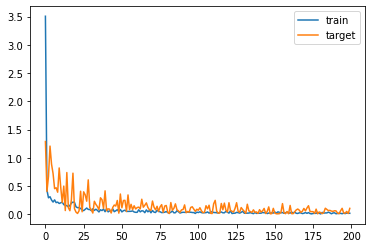

In [175]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='target')
plt.legend();

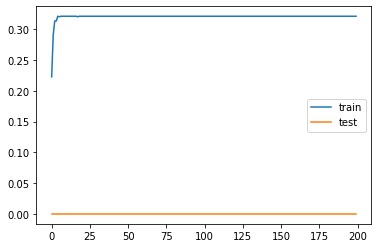

In [176]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend();

In [177]:
history1 = NN_model.fit(train1, test1, epochs=150, batch_size=50, validation_split = 0.2)

Epoch 1/150
24/24 [==============================] - 1s 41ms/step - loss: 3.9522 - accuracy: 0.8581 - val_loss: 5.0808 - val_accuracy: 0.9982
Epoch 2/150
24/24 [==============================] - 0s 16ms/step - loss: 3.7595 - accuracy: 0.9983 - val_loss: 5.0759 - val_accuracy: 0.9982
Epoch 3/150
24/24 [==============================] - 0s 17ms/step - loss: 3.7553 - accuracy: 0.9983 - val_loss: 5.0801 - val_accuracy: 0.9982
Epoch 4/150
24/24 [==============================] - 0s 18ms/step - loss: 3.7551 - accuracy: 0.9983 - val_loss: 5.0791 - val_accuracy: 0.9982
Epoch 5/150
24/24 [==============================] - 0s 16ms/step - loss: 3.7546 - accuracy: 0.9983 - val_loss: 5.0757 - val_accuracy: 0.9982
Epoch 6/150
24/24 [==============================] - 0s 16ms/step - loss: 3.7541 - accuracy: 0.9983 - val_loss: 5.0764 - val_accuracy: 0.9982
Epoch 7/150
24/24 [==============================] - 0s 16ms/step - loss: 3.7540 - accuracy: 0.9983 - val_loss: 5.0794 - val_accuracy: 0.9982
Epoch 

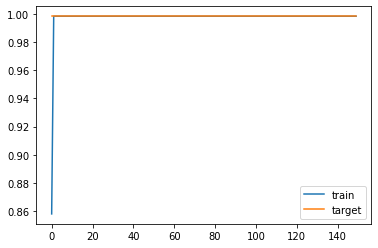

In [179]:
plt.plot(history1.history1['accuracy'], label='train')
plt.plot(history1.history1['val_accuracy'], label='target')
plt.legend();

In [183]:
test1 = tf.stack(test1)
target = tf.stack(target)

In [185]:
history = NN_model.fit(np.array(test1),np.array(target), epochs=150, batch_size=50, validation_split = 0.2)

ValueError: ignored